In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit
from scipy import stats

import dataloader
import preprocessing
import sampling


# Load data

In [2]:
# Load preprocessed ERSP data
ERSP_all, tmp_all, freqs = dataloader.load_data()

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)


# Data preprocessing

In [64]:
#ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 25)
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

## Remain original ERSP

In [65]:
num_epoch = ERSP_all.shape[0]
method = 3 # 1,2,3

if method != 3:
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    
else:
    '''
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    '''
    # Average power over channels (LDA directly)
    ERSP_all = np.mean(ERSP_all, axis=2)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    ERSP_all = preprocessing.bandpower(ERSP_all, freqs, 5, 15)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    

Shape of ERSP_all:  (452, 12)


## Trim mean

In [4]:
ERSP_all, new_SLs = preprocessing.trimMean(ERSP_all, SLs, freqs)
Y = preprocessing.make_target(new_SLs)

method = 3

## Bandpower

In [4]:
ERSP_1 = preprocessing.bandpower(ERSP_all, freqs, 5, 10)
ERSP_2 = preprocessing.bandpower(ERSP_all, freqs, 10, 15)
ERSP_all = np.concatenate((ERSP_1, ERSP_2), axis=1)

threshold = np.mean(SLs)+np.std(SLs)
print(threshold)
Y = preprocessing.make_target(SLs, threshold)

method = 3

25.554513197351692


# Holdout Method

## Split data

In [5]:
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(ERSP_all, Y, test_size=0.1, random_state=42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (406, 1368)
X_test shape :  (46, 1368)


## PCA (1) Largest eigenvalues

In [5]:
# Apply PCA to training data and testing data
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

NameError: name 'X_train' is not defined

## PCA (2) Most correlated

In [5]:
def PCA_corr(X_train, X_test, Y_train):
    # PCA fit
    num_train = X_train.shape[0]
    mean_X = 1/num_train * np.dot(X_train.T, np.ones((num_train,1))).T
    cen_X_train = X_train - mean_X
    cov_X_train = 1/num_train * np.dot(cen_X_train.T, cen_X_train)
    w, v = np.linalg.eig(cov_X_train)

    # Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(w)[::-1]
    sorted_v = v[:, sorted_indices]
    sorted_w = np.sort(w)[::-1]

    # Retain PCs with 80% eigenvalues
    ratios = np.add.accumulate(sorted_w.real)/np.sum(sorted_w.real)
    num_PCs = np.sum(ratios<=0.8)
    PCs = sorted_v[:, :num_PCs]

    # PCA predict
    X_train = np.dot(cen_X_train, PCs)

    # Find two PCs correlated most strongly with SLs
    corr_coef = np.zeros(num_PCs)
    for i in range(num_PCs):
        corr_coef[i] = abs(np.corrcoef(X_train[:,i], Y_train[:,1])[0,1])

    #print(corr_coef)
    max_1_index = np.argmax(corr_coef)
    #print('Max: ', max_1_index)
    corr_coef[max_1_index] = 0
    max_2_index = np.argmax(corr_coef)
    #print('Second: ', max_2_index)
    PC_2 = sorted_v[:, [max_1_index, max_2_index]]


    # PCA predict
    X_train = abs(np.dot(cen_X_train, PC_2))
    X_test = abs(np.dot(X_test-mean_X, PC_2))

    #print('X_train shape : ', X_train.shape)
    #print('X_test shape : ', X_test.shape)
    
    return X_train, X_test

In [7]:
X_train, X_test = PCA_corr(X_train, X_test, Y_train)

[0.10016149 0.13321825 0.19431854 0.1501953  0.1506912  0.05088907
 0.14942456 0.12343108 0.06527064 0.0030398  0.02589858 0.06059784
 0.06922075 0.04778581 0.0834417  0.08851105 0.09370633 0.03329117
 0.08084067 0.00824471 0.00701375 0.09780048 0.05044458 0.0233989 ]
Max:  2
Second:  4


In [8]:
# Sort SLs in increasing order
sorted_indices = np.argsort(Y_train[:,1])
sorted_x = X_train[sorted_indices, :]
sorted_y = Y_train[sorted_indices, :]

# Curve fitting
def func(X, a, b, c):
    x1, x2 = X
    return a + b*x1 + c*x2

xdata = (sorted_x[:,0], sorted_x[:,1])
ydata = sorted_y[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

Text(0.5, 1.0, 'r = 0.043601')

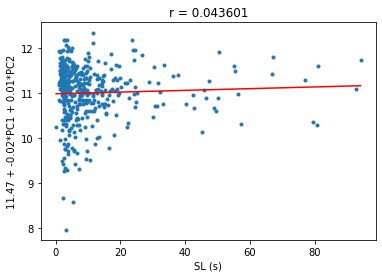

In [9]:
# Plot them
y_reg = func(xdata, popt[0], popt[1], popt[2])
plt.scatter(ydata, y_reg, marker = '.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ydata, y_reg)
y_range = np.linspace(np.min(ydata), np.max(ydata), 100)
plt.plot(y_range, slope*y_range+intercept, 'r-')

plt.xlabel('SL (s)')
plt.ylabel('%.2f + %.2f*PC1 + %.2f*PC2'%(popt[0],popt[1],popt[2]))
plt.title('r = %f'%(np.corrcoef(y_reg, ydata)[0,1]))


# Leave-one-out cross validation

In [5]:
X_all = ERSP_all

test_acc_SL = []
thresholds = list(range(1,50))

for threshold in thresholds:
    Y = preprocessing.make_target(SLs, float(threshold))
    
    train_acc_list = []
    test_acc_list = []
    loo = LeaveOneOut()
    for i, (train_index, test_index) in enumerate(loo.split(X_all)):

        # No trim mean
        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        if method == 1:
            pca = PCA(n_components=2)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            # PCA
            X_train, X_test = PCA_corr(X_train, X_test, Y_train)

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]

        '''
        # Trim mean after removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        X_train, new_SLs = trimMean(X_train, SLs[train_index], freqs)
        X_test = bandpower(X_test, freqs, 10, 15)

        # Let mean of SLs be the threshold
        threshold = np.mean(new_SLs) 
        Y_train = np.asarray(new_SLs >= threshold, float)
        Y_test = np.asarray(SLs[test_index] >= threshold, float)
        '''

        '''
        # Trim mean before removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]
        '''

        # LDA
        clf = svm.SVC()
        clf.fit(X_train, Y_train)

        num_train = len(Y_train)
        pred_train = clf.predict(X_train)
        train_acc = np.sum(pred_train == Y_train)/num_train*100
        #print('Training Accuracy : %f'%(train_acc))
        train_acc_list.append(train_acc)

        num_test = len(Y_test)
        pred_test = clf.predict(X_test)
        test_acc = np.sum(pred_test == Y_test)*100
        #print('Testing Accuracy : %f'%(test_acc))
        test_acc_list.append(test_acc)

        # print('Iteration %d: (%f, %f)'%(i, train_acc, test_acc))
        
    print('Threshold %d: %f'%(threshold, sum(test_acc_list)/len(test_acc_list)))
    test_acc_SL.append(sum(test_acc_list)/len(test_acc_list))
    

Threshold 1: 99.557522
Threshold 2: 88.716814
Threshold 3: 75.663717
Threshold 4: 64.823009
Threshold 5: 62.168142
Threshold 6: 66.150442
Threshold 7: 70.796460
Threshold 8: 70.796460
Threshold 9: 71.902655
Threshold 10: 73.672566
Threshold 11: 76.327434
Threshold 12: 76.106195
Threshold 13: 77.876106
Threshold 14: 77.876106
Threshold 15: 80.973451
Threshold 16: 82.964602
Threshold 17: 83.849558
Threshold 18: 85.176991
Threshold 19: 86.504425
Threshold 20: 87.389381
Threshold 21: 87.610619
Threshold 22: 88.053097
Threshold 23: 88.938053
Threshold 24: 89.601770
Threshold 25: 90.929204
Threshold 26: 91.150442
Threshold 27: 91.371681
Threshold 28: 91.371681
Threshold 29: 91.592920
Threshold 30: 91.592920
Threshold 31: 92.256637
Threshold 32: 92.699115
Threshold 33: 93.141593
Threshold 34: 93.362832
Threshold 35: 93.362832
Threshold 36: 93.362832
Threshold 37: 93.584071
Threshold 38: 94.026549
Threshold 39: 94.026549
Threshold 40: 94.026549
Threshold 41: 94.247788
Threshold 42: 94.247788
T

In [6]:
test_acc_array = np.asarray(test_acc_list)
false_trials = SLs[np.where(test_acc_array==0)[0]]
true_trials = SLs[np.where(test_acc_array==100)[0]]
print('False trials, Min: %f, Max: %f'%(np.min(false_trials), np.max(false_trials)))
print('True trials, Min: %f, Max: %f'%(np.min(true_trials), np.max(true_trials)))

False trials, Min: 26.693359, Max: 94.105469
True trials, Min: 0.152344, Max: 25.238281


In [6]:
print('Training accuracy: %f'%(sum(train_acc_list)/len(train_acc_list)))
print('Testing accuracy: %f'%(sum(test_acc_list)/len(test_acc_list)))

Training accuracy: 91.150442
Testing accuracy: 91.150442


Text(0, 0.5, 'Accuracy (%)')

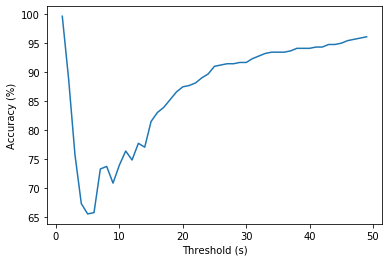

In [9]:
plt.plot(thresholds, test_acc_SL)
plt.xlabel('Threshold (s)')
plt.ylabel('Accuracy (%)')

In [6]:
ratios = []
for threshold in thresholds:
    ratio = max(np.sum(SLs<=threshold), np.sum(SLs>threshold))/len(SLs)
    ratios.append(ratio*100)

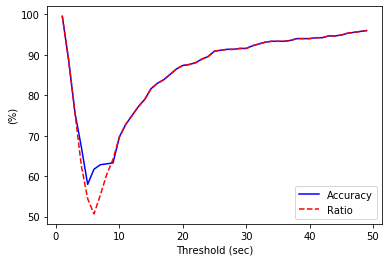

In [7]:
plt.plot(thresholds, test_acc_SL, 'b-', thresholds, ratios, 'r--')
plt.xlabel('Threshold (sec)')
plt.ylabel('(%)')
plt.legend(('Accuracy', 'Ratio'))

# Regression

In [52]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

def plot_scatter(true, pred):

    max_value = np.max(np.hstack((true, pred)))
    plt.scatter(true, pred, marker='.')
    axes = plt.gca()
    axes.set_xlim([0, max_value])
    axes.set_ylim([0, max_value])
    plt.xlabel('True')
    plt.ylabel('Pred')
    
def regression(X_train, Y_train, X_test, Y_test, regressor):
    
    results = regressor.fit(X_train,Y_train)
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    
    train_std = mean_squared_error(Y_train, pred_train)**0.5
    test_std = mean_squared_error(Y_test, pred_test)**0.5
    train_r2 = r2_score(Y_train, pred_train)
    test_r2 = r2_score(Y_test, pred_test)
    
    return results, train_std, test_std, train_r2, test_r2, pred_train, pred_test

In [63]:
num_fold = ERSP_all.shape[0]
train_std = np.zeros((num_fold, 3))
test_std = np.zeros((num_fold, 3))
train_r2 = np.zeros((num_fold, 3))
test_r2 = np.zeros((num_fold, 3))
train_base = np.zeros(num_fold)
test_base = np.zeros(num_fold)
train_base_r2 = np.zeros(num_fold)
test_base_r2 = np.zeros(num_fold)

pred_Y = np.zeros(num_fold)

kf = LeaveOneOut()
#kf = KFold(n_splits=num_fold)
method = 2
select = []

for i, (train_index, test_index) in enumerate(kf.split(ERSP_all)):
    print('---Iteration %d---\n'%(i))
    print(test_index)
    
    # Standardize data
    X_all, Y = preprocessing.standardize(ERSP_all, tmp_all, train_indices=train_index)
    
    # Select correlated ERSP
    X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.75, train_indices=train_index)
    select.append(select_indices)
    
    # Flatten X_all
    X_all = X_all.reshape((X_all.shape[0],-1))
    
    #X_all = preprocessing.bandpower(X_all, freqs, 5, 15)
    
    # Split data
    X_train, X_test = X_all[train_index, :], X_all[test_index, :]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    if method == 1:
        pca = PCA(n_components=0.9)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    elif method == 2:
        # PCA
        X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test)
    
    # 1. Regression directly
    #rgr = svm.SVR()
    #rgr = Ridge(alpha=1)
    rgr = LinearRegression()
    results, train_std[i,0], test_std[i,0], train_r2[i,0], test_r2[i,0], pred_train1, pred_test1 = regression(\
        X_train, Y_train, X_test, Y_test, rgr)
    print('Method 1: %f | %f\n'%(train_std[i,0], test_std[i,0]))
    pred_Y[i] = pred_test1
    
    '''
    # 2. Undersampling -> Regression
    new_X_train, new_Y_train = sampling.undersampling(X_train, Y_train)
    _, train_std[i,1], test_std[i,1], train_r2[i,1], test_r2[i,1], _, _ = regression(\
        new_X_train, new_Y_train, X_test, Y_test, rgr)
    print('Method 2: %f | %f\n'%(train_std[i,1], test_std[i,1]))
    
    # 3. SMOTE -> Regression
    new_X_train, new_Y_train = sampling.SMOTER(X_train, Y_train)
    _, train_std[i,2], test_std[i,2], train_r2[i,2], test_r2[i,2], pred_train2, pred_test2 = regression(\
        new_X_train, new_Y_train, X_test, Y_test, rgr)
    print('Method 3: %f | %f\n'%(train_std[i,2], test_std[i,2]))
    '''
    
    train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
    test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
    print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
    train_base[i] = standard_error(train_baseline, Y_train)
    test_base[i] = standard_error(test_baseline, Y_test)
    train_base_r2[i] = r2_score(Y_train, train_baseline)
    test_base_r2[i] = r2_score(Y_test, test_baseline)
    

---Iteration 0---

[0]
Select 342 features
First: 0, 0.215668
Second: 7, 0.072511
Method 1: 14.595821 | 15.949130

Baseline: 14.597772 | 15.774182

---Iteration 1---

[1]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214198
Second: 7, 0.068568
Method 1: 14.603674 | 11.042845

Baseline: 14.607475 | 10.988203

---Iteration 2---

[2]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212449
Second: 7, 0.071362
Method 1: 14.614191 | 1.288154

Baseline: 14.616477 | 1.349640

---Iteration 3---

[3]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212273
Second: 7, 0.071799
Method 1: 14.614501 | 1.956841

Baseline: 14.616352 | 1.864451

---Iteration 4---

[4]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211709
Second: 7, 0.076265
Method 1: 14.608932 | 7.375127

Baseline: 14.612866 | 7.038006

---Iteration 5---

[5]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211325
Second: 7, 0.075561
Method 1: 14.611095 | 6.056653

Baseline: 14.613458 | 6.458599

---Iteration 6---

[6]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.216592
Second: 7, 0.071510
Method 1: 14.590426 | 17.948636

Baseline: 14.592564 | 17.819724

---Iteration 7---

[7]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211002
Second: 7, 0.075700
Method 1: 14.608612 | 8.625756

Baseline: 14.611093 | 8.541332

---Iteration 8---

[8]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212145
Second: 7, 0.075634
Method 1: 14.613699 | 2.562930

Baseline: 14.615986 | 2.884285

---Iteration 9---

[9]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212039
Second: 7, 0.077176
Method 1: 14.612528 | 3.910229

Baseline: 14.615510 | 3.821906

---Iteration 10---

[10]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.215901
Second: 2, 0.068463
Method 1: 14.563589 | 19.094469

Baseline: 14.584037 | 20.736332

---Iteration 11---

[11]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211369
Second: 7, 0.076521
Method 1: 14.610452 | 6.563912

Baseline: 14.612959 | 6.949920

---Iteration 12---

[12]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211898
Second: 7, 0.072442
Method 1: 14.611968 | 5.985737

Baseline: 14.614110 | 5.753915

---Iteration 13---

[13]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212173
Second: 7, 0.075896
Method 1: 14.613622 | 2.430568

Baseline: 14.615997 | 2.858838

---Iteration 14---

[14]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211405
Second: 7, 0.075911
Method 1: 14.610049 | 7.164938

Baseline: 14.612573 | 7.308135

---Iteration 15---

[15]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.217075
Second: 7, 0.069791
Method 1: 14.585337 | 19.760358

Baseline: 14.587870 | 19.479646

---Iteration 16---

[16]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.221343
Second: 2, 0.069475
Method 1: 14.485652 | 35.604611

Baseline: 14.515354 | 36.515382

---Iteration 17---

[17]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214517
Second: 7, 0.071075
Method 1: 14.600749 | 13.519736

Baseline: 14.602672 | 13.570087

---Iteration 18---

[18]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212616
Second: 7, 0.073742
Method 1: 14.613811 | 0.009414

Baseline: 14.616612 | 0.196698

---Iteration 19---

[19]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.221803
Second: 7, 0.086256
Method 1: 14.465490 | 44.569520

Baseline: 14.466014 | 44.493972

---Iteration 20---

[20]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212547
Second: 7, 0.074461
Method 1: 14.613875 | 0.902045

Baseline: 14.616499 | 1.238065

---Iteration 21---

[21]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211465
Second: 7, 0.075609
Method 1: 14.610947 | 6.553091

Baseline: 14.613058 | 6.855962

---Iteration 22---

[22]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.221264
Second: 2, 0.066974
Method 1: 14.471453 | 37.705543

Baseline: 14.503634 | 38.562881

---Iteration 23---

[23]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212460
Second: 7, 0.072299
Method 1: 14.613908 | 1.447188

Baseline: 14.616439 | 1.525811

---Iteration 24---

[24]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211438
Second: 7, 0.073615
Method 1: 14.608795 | 8.277706

Baseline: 14.611353 | 8.337756

---Iteration 25---

[25]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212220
Second: 7, 0.075650
Method 1: 14.613918 | 2.538274

Baseline: 14.616090 | 2.635688

---Iteration 26---

[26]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212399
Second: 7, 0.075695
Method 1: 14.614410 | 0.769759

Baseline: 14.616564 | 0.821127

---Iteration 27---

[27]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211531
Second: 7, 0.075407
Method 1: 14.609953 | 7.419917

Baseline: 14.613276 | 6.642600

---Iteration 28---

[28]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211538
Second: 7, 0.075605
Method 1: 14.610523 | 7.061799

Baseline: 14.612734 | 7.161326

---Iteration 29---

[29]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212912
Second: 7, 0.074534
Method 1: 14.614464 | 0.791684

Baseline: 14.616595 | 0.517773

---Iteration 30---

[30]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211374
Second: 7, 0.074983
Method 1: 14.610308 | 7.268411

Baseline: 14.612320 | 7.533242

---Iteration 31---

[31]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212515
Second: 7, 0.075757
Method 1: 14.614074 | 1.198405

Baseline: 14.616476 | 1.357470

---Iteration 32---

[32]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211475
Second: 7, 0.073403
Method 1: 14.609763 | 7.922983

Baseline: 14.611698 | 8.059798

---Iteration 33---

[33]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212219
Second: 7, 0.076668
Method 1: 14.613615 | 2.593408

Baseline: 14.616115 | 2.571092

---Iteration 34---

[34]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212266
Second: 7, 0.075179
Method 1: 14.613845 | 2.487249

Baseline: 14.616278 | 2.111090

---Iteration 35---

[35]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212055
Second: 7, 0.074222
Method 1: 14.613314 | 3.998048

Baseline: 14.615367 | 4.060716

---Iteration 36---

[36]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212341
Second: 7, 0.076424
Method 1: 14.614002 | 2.384458

Baseline: 14.616293 | 2.064111

---Iteration 37---

[37]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213537
Second: 7, 0.076618
Method 1: 14.611462 | 6.106697

Baseline: 14.613925 | 5.961457

---Iteration 38---

[38]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212129
Second: 7, 0.075855
Method 1: 14.612936 | 4.314779

Baseline: 14.615525 | 3.796459

---Iteration 39---

[39]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211448
Second: 7, 0.075141
Method 1: 14.608649 | 8.867759

Baseline: 14.610562 | 8.942610

---Iteration 40---

[40]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211742
Second: 7, 0.075119
Method 1: 14.610920 | 6.837034

Baseline: 14.613072 | 6.842260

---Iteration 41---

[41]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214166
Second: 7, 0.078373
Method 1: 14.601710 | 13.151943

Baseline: 14.603108 | 13.356725

---Iteration 42---

[42]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212716
Second: 7, 0.077746
Method 1: 14.614211 | 1.725752

Baseline: 14.616374 | 1.784247

---Iteration 43---

[43]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211985
Second: 7, 0.075144
Method 1: 14.609984 | 6.982061

Baseline: 14.613422 | 6.495791

---Iteration 44---

[44]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211831
Second: 7, 0.076649
Method 1: 14.611985 | 4.865529

Baseline: 14.614773 | 4.933741

---Iteration 45---

[45]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212525
Second: 7, 0.078376
Method 1: 14.613976 | 0.482692

Baseline: 14.616607 | 0.339593

---Iteration 46---

[46]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211911
Second: 7, 0.077451
Method 1: 14.611812 | 5.550878

Baseline: 14.614873 | 4.798677

---Iteration 47---

[47]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212946
Second: 7, 0.077864
Method 1: 14.612575 | 3.160865

Baseline: 14.615675 | 3.524425

---Iteration 48---

[48]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211551
Second: 7, 0.075720
Method 1: 14.609805 | 7.836406

Baseline: 14.611815 | 7.963882

---Iteration 49---

[49]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212696
Second: 7, 0.079586
Method 1: 14.614043 | 0.614906

Baseline: 14.616564 | 0.823136

---Iteration 50---

[50]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212632
Second: 7, 0.076158
Method 1: 14.613571 | 0.549345

Baseline: 14.616576 | 0.719339

---Iteration 51---

[51]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212291
Second: 7, 0.078375
Method 1: 14.614395 | 0.202726

Baseline: 14.616580 | 0.680242

---Iteration 52---

[52]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211241
Second: 7, 0.075445
Method 1: 14.609409 | 7.697151

Baseline: 14.611904 | 7.889499

---Iteration 53---

[53]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211699
Second: 7, 0.075580
Method 1: 14.612374 | 5.115557

Baseline: 14.614303 | 5.526850

---Iteration 54---

[54]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211220
Second: 7, 0.076209
Method 1: 14.609426 | 8.309443

Baseline: 14.611060 | 8.566779

---Iteration 55---

[55]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211364
Second: 7, 0.074133
Method 1: 14.606842 | 9.719486

Baseline: 14.609243 | 9.868487

---Iteration 56---

[56]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210843
Second: 7, 0.073036
Method 1: 14.608979 | 8.998255

Baseline: 14.610447 | 9.026781

---Iteration 57---

[57]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211275
Second: 7, 0.076203
Method 1: 14.606974 | 9.858149

Baseline: 14.609507 | 9.690358

---Iteration 58---

[58]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211458
Second: 7, 0.069551
Method 1: 14.610332 | 8.056496

Baseline: 14.611727 | 8.036308

---Iteration 59---

[59]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211245
Second: 7, 0.076194
Method 1: 14.610168 | 7.560516

Baseline: 14.612360 | 7.498008

---Iteration 60---

[60]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211489
Second: 7, 0.076474
Method 1: 14.610776 | 6.415827

Baseline: 14.613138 | 6.777664

---Iteration 61---

[61]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211371
Second: 7, 0.074940
Method 1: 14.609069 | 8.213898

Baseline: 14.611309 | 8.372991

---Iteration 62---

[62]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211216
Second: 7, 0.073265
Method 1: 14.609812 | 8.218448

Baseline: 14.611466 | 8.247713

---Iteration 63---

[63]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211764
Second: 7, 0.075399
Method 1: 14.612162 | 5.223508

Baseline: 14.614391 | 5.421147

---Iteration 64---

[64]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211293
Second: 7, 0.073420
Method 1: 14.610856 | 6.618347

Baseline: 14.613138 | 6.777664

---Iteration 65---

[65]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211108
Second: 7, 0.074309
Method 1: 14.610620 | 7.101535

Baseline: 14.612367 | 7.492136

---Iteration 66---

[66]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211936
Second: 7, 0.075490
Method 1: 14.612962 | 4.301640

Baseline: 14.615055 | 4.540292

---Iteration 67---

[67]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212066
Second: 7, 0.075657
Method 1: 14.613490 | 3.205651

Baseline: 14.615664 | 3.545905

---Iteration 68---

[68]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211888
Second: 7, 0.075634
Method 1: 14.612921 | 4.262740

Baseline: 14.615020 | 4.591186

---Iteration 69---

[69]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212045
Second: 7, 0.077544
Method 1: 14.612114 | 3.913643

Baseline: 14.615540 | 3.769055

---Iteration 70---

[70]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211289
Second: 7, 0.075720
Method 1: 14.610340 | 7.263842

Baseline: 14.612212 | 7.627200

---Iteration 71---

[71]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211638
Second: 7, 0.074017
Method 1: 14.610837 | 5.893027

Baseline: 14.613904 | 5.984895

---Iteration 72---

[72]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211139
Second: 7, 0.074946
Method 1: 14.607577 | 8.837821

Baseline: 14.610229 | 9.185335

---Iteration 73---

[73]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211359
Second: 7, 0.075681
Method 1: 14.609166 | 7.198006

Baseline: 14.612466 | 7.404050

---Iteration 74---

[74]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210906
Second: 7, 0.077641
Method 1: 14.607266 | 9.573774

Baseline: 14.609426 | 9.745167

---Iteration 75---

[75]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211326
Second: 7, 0.074419
Method 1: 14.607834 | 9.540777

Baseline: 14.609556 | 9.657081

---Iteration 76---

[76]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211542
Second: 7, 0.076288
Method 1: 14.610121 | 7.679166

Baseline: 14.612155 | 7.676136

---Iteration 77---

[77]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210578
Second: 7, 0.075955
Method 1: 14.607604 | 9.368763

Baseline: 14.609290 | 9.837167

---Iteration 78---

[78]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211758
Second: 7, 0.077155
Method 1: 14.608906 | 8.402237

Baseline: 14.611420 | 8.284905

---Iteration 79---

[79]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211613
Second: 7, 0.071793
Method 1: 14.609942 | 8.005136

Baseline: 14.611862 | 7.924733

---Iteration 80---

[80]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211966
Second: 7, 0.075746
Method 1: 14.613211 | 4.077334

Baseline: 14.615245 | 4.254504

---Iteration 81---

[81]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211263
Second: 7, 0.076328
Method 1: 14.608225 | 8.982596

Baseline: 14.610240 | 9.177505

---Iteration 82---

[82]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210768
Second: 7, 0.072584
Method 1: 14.607361 | 9.124885

Baseline: 14.609670 | 9.578783

---Iteration 83---

[83]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212090
Second: 7, 0.075700
Method 1: 14.613550 | 3.287468

Baseline: 14.615657 | 3.557650

---Iteration 84---

[84]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211244
Second: 7, 0.075805
Method 1: 14.609855 | 6.690316

Baseline: 14.612879 | 7.026261

---Iteration 85---

[85]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212051
Second: 7, 0.075723
Method 1: 14.613242 | 4.005490

Baseline: 14.615346 | 4.095950

---Iteration 86---

[86]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211569
Second: 7, 0.073466
Method 1: 14.610635 | 7.100980

Baseline: 14.612689 | 7.202432

---Iteration 87---

[87]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210912
Second: 7, 0.076172
Method 1: 14.608577 | 8.480158

Baseline: 14.610580 | 8.928908

---Iteration 88---

[88]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211306
Second: 7, 0.075515
Method 1: 14.606996 | 9.335028

Baseline: 14.609718 | 9.545507

---Iteration 89---

[89]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211206
Second: 7, 0.073715
Method 1: 14.607708 | 9.513286

Baseline: 14.609467 | 9.717763

---Iteration 90---

[90]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211043
Second: 7, 0.073606
Method 1: 14.607822 | 9.416698

Baseline: 14.609833 | 9.465251

---Iteration 91---

[91]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211290
Second: 7, 0.076480
Method 1: 14.607463 | 9.573239

Baseline: 14.609579 | 9.641422

---Iteration 92---

[92]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210854
Second: 7, 0.074310
Method 1: 14.608438 | 8.966364

Baseline: 14.610111 | 9.269505

---Iteration 93---

[93]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211041
Second: 7, 0.075742
Method 1: 14.609469 | 7.963852

Baseline: 14.611266 | 8.406267

---Iteration 94---

[94]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211596
Second: 7, 0.075593
Method 1: 14.612073 | 5.318989

Baseline: 14.614034 | 5.840043

---Iteration 95---

[95]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211664
Second: 7, 0.075714
Method 1: 14.612351 | 4.926264

Baseline: 14.614328 | 5.497488

---Iteration 96---

[96]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211168
Second: 7, 0.073821
Method 1: 14.609494 | 8.281135

Baseline: 14.611156 | 8.492395

---Iteration 97---

[97]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210914
Second: 7, 0.075394
Method 1: 14.606928 | 9.846839

Baseline: 14.609185 | 9.907636

---Iteration 98---

[98]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211232
Second: 7, 0.073637
Method 1: 14.609571 | 8.057895

Baseline: 14.611571 | 8.163543

---Iteration 99---

[99]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211201
Second: 7, 0.075035
Method 1: 14.609827 | 7.592462

Baseline: 14.611955 | 7.846435

---Iteration 100---

[100]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211449
Second: 7, 0.075414
Method 1: 14.611662 | 5.803781

Baseline: 14.613674 | 6.233492

---Iteration 101---

[101]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211426
Second: 7, 0.075119
Method 1: 14.608673 | 9.035933

Baseline: 14.610378 | 9.077675

---Iteration 102---

[102]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210828
Second: 7, 0.071488
Method 1: 14.608670 | 9.127685

Baseline: 14.610394 | 9.065930

---Iteration 103---

[103]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211063
Second: 7, 0.074371
Method 1: 14.609931 | 7.609344

Baseline: 14.611824 | 7.956053

---Iteration 104---

[104]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211061
Second: 7, 0.078448
Method 1: 14.605068 | 9.988585

Baseline: 14.609867 | 9.441761

---Iteration 105---

[105]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210974
Second: 7, 0.074024
Method 1: 14.607297 | 9.792500

Baseline: 14.609226 | 9.880231

---Iteration 106---

[106]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211281
Second: 7, 0.075280
Method 1: 14.610962 | 6.336381

Baseline: 14.613325 | 6.593663

---Iteration 107---

[107]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212250
Second: 7, 0.076103
Method 1: 14.613939 | 2.184680

Baseline: 14.616224 | 2.273559

---Iteration 108---

[108]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211257
Second: 7, 0.076963
Method 1: 14.607317 | 9.537764

Baseline: 14.609604 | 9.623805

---Iteration 109---

[109]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211147
Second: 7, 0.075737
Method 1: 14.608722 | 8.427939

Baseline: 14.610935 | 8.662694

---Iteration 110---

[110]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211704
Second: 7, 0.075361
Method 1: 14.611623 | 5.972615

Baseline: 14.613742 | 6.161066

---Iteration 111---

[111]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211878
Second: 7, 0.076748
Method 1: 14.609499 | 6.759630

Baseline: 14.613435 | 6.482088

---Iteration 112---

[112]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210644
Second: 7, 0.075203
Method 1: 14.606698 | 9.706471

Baseline: 14.609055 | 9.993764

---Iteration 113---

[113]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211951
Second: 7, 0.077036
Method 1: 14.612936 | 4.499836

Baseline: 14.615094 | 4.483526

---Iteration 114---

[114]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212094
Second: 7, 0.075321
Method 1: 14.613878 | 3.760709

Baseline: 14.615620 | 3.626161

---Iteration 115---

[115]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211198
Second: 7, 0.077145
Method 1: 14.608745 | 8.519429

Baseline: 14.611128 | 8.513927

---Iteration 116---

[116]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210882
Second: 7, 0.073525
Method 1: 14.608261 | 8.580055

Baseline: 14.610683 | 8.852567

---Iteration 117---

[117]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211273
Second: 7, 0.076647
Method 1: 14.610554 | 6.786594

Baseline: 14.612833 | 7.069325

---Iteration 118---

[118]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211358
Second: 7, 0.075340
Method 1: 14.610521 | 7.103737

Baseline: 14.612581 | 7.300305

---Iteration 119---

[119]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211241
Second: 7, 0.074944
Method 1: 14.610461 | 7.433809

Baseline: 14.612087 | 7.734860

---Iteration 120---

[120]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211356
Second: 7, 0.074834
Method 1: 14.610254 | 7.420703

Baseline: 14.612162 | 7.670264

---Iteration 121---

[121]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211586
Second: 7, 0.075474
Method 1: 14.612024 | 5.345663

Baseline: 14.614027 | 5.847873

---Iteration 122---

[122]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210830
Second: 7, 0.073179
Method 1: 14.609331 | 8.486556

Baseline: 14.610806 | 8.760567

---Iteration 123---

[123]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211958
Second: 7, 0.074790
Method 1: 14.611237 | 6.876973

Baseline: 14.613226 | 6.691536

---Iteration 124---

[124]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212356
Second: 7, 0.076341
Method 1: 14.614297 | 1.049117

Baseline: 14.616546 | 0.960106

---Iteration 125---

[125]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212357
Second: 7, 0.076636
Method 1: 14.614565 | 1.098010

Baseline: 14.616570 | 0.772190

---Iteration 126---

[126]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212012
Second: 7, 0.075256
Method 1: 14.610832 | 7.018406

Baseline: 14.612959 | 6.949920

---Iteration 127---

[127]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212255
Second: 7, 0.075433
Method 1: 14.613591 | 3.803440

Baseline: 14.615436 | 3.947235

---Iteration 128---

[128]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212389
Second: 7, 0.072151
Method 1: 14.607445 | 9.334318

Baseline: 14.610370 | 9.083547

---Iteration 129---

[129]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211672
Second: 7, 0.076190
Method 1: 14.612087 | 5.063164

Baseline: 14.614618 | 5.137316

---Iteration 130---

[130]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212179
Second: 7, 0.071863
Method 1: 14.610344 | 7.840594

Baseline: 14.612333 | 7.521497

---Iteration 131---

[131]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211840
Second: 7, 0.075680
Method 1: 14.608330 | 9.261072

Baseline: 14.610329 | 9.112909

---Iteration 132---

[132]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211603
Second: 7, 0.074247
Method 1: 14.607713 | 9.300443

Baseline: 14.610297 | 9.136398

---Iteration 133---

[133]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211723
Second: 7, 0.074380
Method 1: 14.607734 | 9.976197

Baseline: 14.609438 | 9.737337

---Iteration 134---

[134]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212243
Second: 7, 0.075949
Method 1: 14.613396 | 3.973572

Baseline: 14.615506 | 3.827779

---Iteration 135---

[135]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212008
Second: 7, 0.075379
Method 1: 14.607854 | 9.502565

Baseline: 14.610150 | 9.242101

---Iteration 136---

[136]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211898
Second: 7, 0.076343
Method 1: 14.607591 | 9.334664

Baseline: 14.610607 | 8.909333

---Iteration 137---

[137]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212198
Second: 7, 0.075813
Method 1: 14.613717 | 2.970686

Baseline: 14.615937 | 2.993902

---Iteration 138---

[138]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212572
Second: 7, 0.076322
Method 1: 14.613880 | 2.743103

Baseline: 14.615903 | 3.068338

---Iteration 139---

[139]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212231
Second: 7, 0.072301
Method 1: 14.611074 | 6.503214

Baseline: 14.613847 | 6.047533

---Iteration 140---

[140]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212446
Second: 7, 0.076379
Method 1: 14.614251 | 0.293551

Baseline: 14.616611 | 0.243677

---Iteration 141---

[141]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212388
Second: 7, 0.073364
Method 1: 14.611250 | 7.164203

Baseline: 14.613035 | 6.877494

---Iteration 142---

[142]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212390
Second: 7, 0.074243
Method 1: 14.614648 | 0.538065

Baseline: 14.616607 | 0.331763

---Iteration 143---

[143]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212358
Second: 7, 0.075647
Method 1: 14.614508 | 1.110828

Baseline: 14.616549 | 0.934659

---Iteration 144---

[144]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211942
Second: 7, 0.075564
Method 1: 14.607616 | 9.453780

Baseline: 14.610048 | 9.314527

---Iteration 145---

[145]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211192
Second: 7, 0.077688
Method 1: 14.608392 | 8.839277

Baseline: 14.610429 | 9.040483

---Iteration 146---

[146]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211992
Second: 7, 0.073552
Method 1: 14.608590 | 8.691071

Baseline: 14.611063 | 8.564821

---Iteration 147---

[147]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212271
Second: 7, 0.075172
Method 1: 14.609515 | 8.710337

Baseline: 14.611395 | 8.304480

---Iteration 148---

[148]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212090
Second: 7, 0.074355
Method 1: 14.613030 | 4.683278

Baseline: 14.615124 | 4.438505

---Iteration 149---

[149]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212336
Second: 7, 0.075803
Method 1: 14.614078 | 1.756961

Baseline: 14.616399 | 1.692194

---Iteration 150---

[150]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211962
Second: 7, 0.073377
Method 1: 14.609083 | 8.812822

Baseline: 14.610873 | 8.709673

---Iteration 151---

[151]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212099
Second: 7, 0.075509
Method 1: 14.608272 | 8.897602

Baseline: 14.610999 | 8.613758

---Iteration 152---

[152]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212166
Second: 7, 0.076692
Method 1: 14.613502 | 3.234402

Baseline: 14.615831 | 3.219010

---Iteration 153---

[153]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212052
Second: 7, 0.074148
Method 1: 14.608020 | 9.301550

Baseline: 14.610337 | 9.107036

---Iteration 154---

[154]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211844
Second: 7, 0.074974
Method 1: 14.607967 | 9.412592

Baseline: 14.610152 | 9.240143

---Iteration 155---

[155]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211977
Second: 7, 0.074142
Method 1: 14.612842 | 5.072445

Baseline: 14.614755 | 4.957230

---Iteration 156---

[156]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212019
Second: 7, 0.075690
Method 1: 14.611845 | 5.985672

Baseline: 14.613941 | 5.943788

---Iteration 157---

[157]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212371
Second: 7, 0.076367
Method 1: 14.614324 | 1.502993

Baseline: 14.616509 | 1.183256

---Iteration 158---

[158]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212238
Second: 7, 0.075154
Method 1: 14.609816 | 8.081363

Baseline: 14.611888 | 7.903201

---Iteration 159---

[159]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211774
Second: 7, 0.076199
Method 1: 14.606873 | 9.995330

Baseline: 14.609255 | 9.860657

---Iteration 160---

[160]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212116
Second: 7, 0.075628
Method 1: 14.606645 | 9.951367

Baseline: 14.609658 | 9.586613

---Iteration 161---

[161]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211298
Second: 7, 0.076759
Method 1: 14.608220 | 8.492811

Baseline: 14.611080 | 8.551119

---Iteration 162---

[162]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212000
Second: 7, 0.073895
Method 1: 14.608810 | 8.795127

Baseline: 14.611103 | 8.533502

---Iteration 163---

[163]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212031
Second: 7, 0.077007
Method 1: 14.607724 | 9.388310

Baseline: 14.610196 | 9.208824

---Iteration 164---

[164]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212284
Second: 7, 0.077412
Method 1: 14.608984 | 8.255961

Baseline: 14.611925 | 7.871882

---Iteration 165---

[165]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211839
Second: 7, 0.073033
Method 1: 14.607404 | 9.159810

Baseline: 14.610210 | 9.199037

---Iteration 166---

[166]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212248
Second: 7, 0.075741
Method 1: 14.613726 | 3.226945

Baseline: 14.615858 | 3.164201

---Iteration 167---

[167]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211471
Second: 7, 0.076112
Method 1: 14.606812 | 9.840880

Baseline: 14.609610 | 9.619890

---Iteration 168---

[168]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212370
Second: 7, 0.073705
Method 1: 14.614727 | 0.142983

Baseline: 14.616596 | 0.509943

---Iteration 169---

[169]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212617
Second: 7, 0.075280
Method 1: 14.614074 | 2.137418

Baseline: 14.616237 | 2.234462

---Iteration 170---

[170]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211493
Second: 7, 0.073753
Method 1: 14.610616 | 7.495695

Baseline: 14.612304 | 7.546944

---Iteration 171---

[171]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212225
Second: 7, 0.078021
Method 1: 14.606949 | 10.189230

Baseline: 14.609544 | 9.664911

---Iteration 172---

[172]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212111
Second: 7, 0.077527
Method 1: 14.608389 | 8.402560

Baseline: 14.611744 | 8.022606

---Iteration 173---

[173]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211972
Second: 7, 0.075222
Method 1: 14.607487 | 9.883759

Baseline: 14.609458 | 9.723635

---Iteration 174---

[174]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212601
Second: 7, 0.073867
Method 1: 14.612139 | 6.160533

Baseline: 14.613536 | 6.378395

---Iteration 175---

[175]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211587
Second: 7, 0.077559
Method 1: 14.609216 | 6.828304

Baseline: 14.613342 | 6.576046

---Iteration 176---

[176]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212114
Second: 7, 0.073351
Method 1: 14.609824 | 7.987423

Baseline: 14.612192 | 7.644817

---Iteration 177---

[177]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212074
Second: 7, 0.075226
Method 1: 14.607446 | 9.366214

Baseline: 14.610307 | 9.128568

---Iteration 178---

[178]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212117
Second: 7, 0.073723
Method 1: 14.612204 | 5.591947

Baseline: 14.614521 | 5.260636

---Iteration 179---

[179]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211949
Second: 7, 0.072658
Method 1: 14.608812 | 8.866738

Baseline: 14.610935 | 8.662694

---Iteration 180---

[180]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212894
Second: 7, 0.076509
Method 1: 14.612656 | 4.435208

Baseline: 14.615167 | 4.373961

---Iteration 181---

[181]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211731
Second: 7, 0.076946
Method 1: 14.607518 | 9.527727

Baseline: 14.610037 | 9.322357

---Iteration 182---

[182]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211479
Second: 7, 0.073560
Method 1: 14.608006 | 9.272830

Baseline: 14.610283 | 9.146186

---Iteration 183---

[183]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212244
Second: 7, 0.075367
Method 1: 14.610063 | 7.678687

Baseline: 14.611944 | 7.856274

---Iteration 184---

[184]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211897
Second: 7, 0.070873
Method 1: 14.608055 | 9.250951

Baseline: 14.610223 | 9.189250

---Iteration 185---

[185]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212564
Second: 7, 0.076532
Method 1: 14.607957 | 8.918375

Baseline: 14.611948 | 7.852307

---Iteration 186---

[186]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211589
Second: 7, 0.076746
Method 1: 14.610760 | 7.329282

Baseline: 14.612635 | 7.251368

---Iteration 187---

[187]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212042
Second: 7, 0.075544
Method 1: 14.612328 | 5.586132

Baseline: 14.614410 | 5.397658

---Iteration 188---

[188]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212037
Second: 7, 0.076285
Method 1: 14.609861 | 8.210351

Baseline: 14.611843 | 7.940393

---Iteration 189---

[189]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212297
Second: 7, 0.078986
Method 1: 14.612862 | 3.807616

Baseline: 14.615751 | 3.379521

---Iteration 190---

[190]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212500
Second: 7, 0.075775
Method 1: 14.613791 | 3.144580

Baseline: 14.615814 | 3.254296

---Iteration 191---

[191]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.217416
Second: 7, 0.066831
Method 1: 14.281248 | 65.986337

Baseline: 14.282921 | 66.022069

---Iteration 192---

[192]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212342
Second: 7, 0.079452
Method 1: 14.613515 | 1.947515

Baseline: 14.616117 | 2.567229

---Iteration 193---

[193]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212251
Second: 7, 0.074200
Method 1: 14.614150 | 3.088057

Baseline: 14.615792 | 3.297360

---Iteration 194---

[194]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214354
Second: 7, 0.084129
Method 1: 14.565425 | 25.299661

Baseline: 14.567545 | 25.442056

---Iteration 195---

[195]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.217919
Second: 7, 0.079591
Method 1: 14.520296 | 34.823572

Baseline: 14.523421 | 35.035546

---Iteration 196---

[196]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.220355
Second: 7, 0.068553
Method 1: 14.163651 | 76.502387

Baseline: 14.165711 | 76.590372

---Iteration 197---

[197]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.217232
Second: 7, 0.081997
Method 1: 14.451121 | 46.301261

Baseline: 14.452505 | 46.435768

---Iteration 198---

[198]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212443
Second: 7, 0.075988
Method 1: 14.614280 | 0.587545

Baseline: 14.616544 | 0.973860

---Iteration 199---

[199]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212435
Second: 7, 0.074698
Method 1: 14.613658 | 3.069394

Baseline: 14.615977 | 2.903859

---Iteration 200---

[200]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212483
Second: 7, 0.072721
Method 1: 14.614873 | 0.808645

Baseline: 14.616565 | 0.813297

---Iteration 201---

[201]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212574
Second: 7, 0.072738
Method 1: 14.609400 | 8.552181

Baseline: 14.610759 | 8.795853

---Iteration 202---

[202]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212511
Second: 7, 0.075497
Method 1: 14.614422 | 0.421995

Baseline: 14.616607 | 0.339645

---Iteration 203---

[203]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212238
Second: 7, 0.074562
Method 1: 14.614074 | 3.335056

Baseline: 14.615618 | 3.630127

---Iteration 204---

[204]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212283
Second: 7, 0.064514
Method 1: 14.484687 | 41.512227

Baseline: 14.487671 | 41.185872

---Iteration 205---

[205]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213757
Second: 7, 0.073206
Method 1: 14.538280 | 31.539991

Baseline: 14.540752 | 31.619786

---Iteration 206---

[206]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212280
Second: 7, 0.076339
Method 1: 14.613710 | 3.160450

Baseline: 14.615719 | 3.442212

---Iteration 207---

[207]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212123
Second: 7, 0.076852
Method 1: 14.609614 | 7.341319

Baseline: 14.612096 | 7.727082

---Iteration 208---

[208]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.226021
Second: 5, 0.074358
Method 1: 14.069224 | 83.068463

Baseline: 14.081219 | 83.335764

---Iteration 209---

[209]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212169
Second: 7, 0.074586
Method 1: 14.613855 | 3.897603

Baseline: 14.615397 | 4.011831

---Iteration 210---

[210]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212468
Second: 7, 0.077224
Method 1: 14.606870 | 10.041581

Baseline: 14.608509 | 10.348115

---Iteration 211---

[211]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214565
Second: 7, 0.067865
Method 1: 14.611881 | 6.737349

Baseline: 14.613283 | 6.634770

---Iteration 212---

[212]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.207567
Second: 7, 0.095664
Method 1: 14.579793 | 21.426902

Baseline: 14.582611 | 21.184590

---Iteration 213---

[213]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210541
Second: 7, 0.076885
Method 1: 14.605019 | 11.583906

Baseline: 14.606608 | 11.497142

---Iteration 214---

[214]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.215071
Second: 7, 0.072348
Method 1: 14.609038 | 8.180727

Baseline: 14.610996 | 8.615715

---Iteration 215---

[215]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.215681
Second: 7, 0.073004
Method 1: 14.609285 | 8.696473

Baseline: 14.610557 | 8.946525

---Iteration 216---

[216]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214513
Second: 7, 0.075222
Method 1: 14.611913 | 5.767188

Baseline: 14.614055 | 5.816553

---Iteration 217---

[217]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213211
Second: 7, 0.076576
Method 1: 14.614580 | 0.874932

Baseline: 14.616496 | 1.253724

---Iteration 218---

[218]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213012
Second: 7, 0.076112
Method 1: 14.614819 | 0.495311

Baseline: 14.616566 | 0.811339

---Iteration 219---

[219]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.216165
Second: 7, 0.073329
Method 1: 14.608870 | 8.767154

Baseline: 14.610283 | 9.146186

---Iteration 220---

[220]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213584
Second: 7, 0.075070
Method 1: 14.614780 | 1.788438

Baseline: 14.616312 | 2.001472

---Iteration 221---

[221]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211014
Second: 7, 0.073586
Method 1: 14.607575 | 9.735131

Baseline: 14.610028 | 9.328281

---Iteration 222---

[222]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213294
Second: 7, 0.075043
Method 1: 14.614764 | 0.807546

Baseline: 14.616536 | 1.020787

---Iteration 223---

[223]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214792
Second: 7, 0.070878
Method 1: 14.610268 | 6.910687

Baseline: 14.612706 | 7.186772

---Iteration 224---

[224]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214920
Second: 7, 0.076773
Method 1: 14.608892 | 8.107135

Baseline: 14.611358 | 8.333841

---Iteration 225---

[225]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208558
Second: 7, 0.080640
Method 1: 14.575695 | 22.753832

Baseline: 14.579649 | 22.086977

---Iteration 226---

[226]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210937
Second: 7, 0.076648
Method 1: 14.608601 | 9.007588

Baseline: 14.611395 | 8.304532

---Iteration 227---

[227]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214921
Second: 7, 0.075044
Method 1: 14.612144 | 5.881945

Baseline: 14.613551 | 6.362684

---Iteration 228---

[228]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214769
Second: 7, 0.077200
Method 1: 14.608627 | 7.636035

Baseline: 14.611960 | 7.842520

---Iteration 229---

[229]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212134
Second: 7, 0.076745
Method 1: 14.613749 | 3.714918

Baseline: 14.615725 | 3.430467

---Iteration 230---

[230]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208301
Second: 7, 0.088589
Method 1: 14.575321 | 22.870912

Baseline: 14.578445 | 22.443234

---Iteration 231---

[231]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214808
Second: 7, 0.077666
Method 1: 14.609921 | 7.172989

Baseline: 14.612217 | 7.623285

---Iteration 232---

[232]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214449
Second: 7, 0.071832
Method 1: 14.614127 | 4.109512

Baseline: 14.615267 | 4.221227

---Iteration 233---

[233]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214564
Second: 7, 0.074839
Method 1: 14.612081 | 5.812963

Baseline: 14.613862 | 6.031874

---Iteration 234---

[234]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214471
Second: 7, 0.073662
Method 1: 14.608693 | 8.861928

Baseline: 14.610386 | 9.071802

---Iteration 235---

[235]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211948
Second: 7, 0.077261
Method 1: 14.613455 | 4.808207

Baseline: 14.615114 | 4.454216

---Iteration 236---

[236]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214934
Second: 7, 0.069054
Method 1: 14.610028 | 8.017436

Baseline: 14.611520 | 8.204649

---Iteration 237---

[237]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212903
Second: 7, 0.075460
Method 1: 14.614877 | 0.789136

Baseline: 14.616585 | 0.629348

---Iteration 238---

[238]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.215417
Second: 7, 0.074216
Method 1: 14.609270 | 8.225619

Baseline: 14.610881 | 8.703801

---Iteration 239---

[239]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214381
Second: 7, 0.075424
Method 1: 14.611260 | 6.984907

Baseline: 14.612862 | 7.041921

---Iteration 240---

[240]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214967
Second: 7, 0.075742
Method 1: 14.612251 | 5.654102

Baseline: 14.613766 | 6.135619

---Iteration 241---

[241]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214092
Second: 7, 0.073906
Method 1: 14.613310 | 4.176310

Baseline: 14.615154 | 4.393483

---Iteration 242---

[242]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209982
Second: 7, 0.081025
Method 1: 14.601441 | 13.149838

Baseline: 14.603676 | 13.072894

---Iteration 243---

[243]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212214
Second: 7, 0.073924
Method 1: 14.614129 | 3.795510

Baseline: 14.615708 | 3.461786

---Iteration 244---

[244]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212911
Second: 7, 0.076407
Method 1: 14.614612 | 0.884681

Baseline: 14.616597 | 0.492326

---Iteration 245---

[245]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214267
Second: 7, 0.072954
Method 1: 14.612011 | 6.083925

Baseline: 14.613591 | 6.321577

---Iteration 246---

[246]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213005
Second: 7, 0.075330
Method 1: 14.614094 | 3.106141

Baseline: 14.615843 | 3.193563

---Iteration 247---

[247]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210598
Second: 7, 0.079347
Method 1: 14.600769 | 13.449525

Baseline: 14.602805 | 13.505491

---Iteration 248---

[248]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214576
Second: 7, 0.075709
Method 1: 14.610389 | 7.316137

Baseline: 14.612429 | 7.437327

---Iteration 249---

[249]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210741
Second: 7, 0.081145
Method 1: 14.604100 | 11.603976

Baseline: 14.606378 | 11.628291

---Iteration 250---

[250]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214554
Second: 7, 0.076783
Method 1: 14.608104 | 9.012316

Baseline: 14.610297 | 9.136398

---Iteration 251---

[251]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210542
Second: 7, 0.074825
Method 1: 14.603746 | 11.816699

Baseline: 14.607073 | 11.227013

---Iteration 252---

[252]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213947
Second: 7, 0.073981
Method 1: 14.610743 | 7.279011

Baseline: 14.612404 | 7.458859

---Iteration 253---

[253]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213958
Second: 7, 0.073152
Method 1: 14.612185 | 5.860329

Baseline: 14.614236 | 5.607106

---Iteration 254---

[254]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214481
Second: 7, 0.073599
Method 1: 14.610783 | 7.576837

Baseline: 14.612034 | 7.779882

---Iteration 255---

[255]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214768
Second: 7, 0.071732
Method 1: 14.608652 | 8.980898

Baseline: 14.610670 | 8.862354

---Iteration 256---

[256]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210206
Second: 7, 0.075565
Method 1: 14.602734 | 12.966299

Baseline: 14.604266 | 12.771445

---Iteration 257---

[257]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212378
Second: 7, 0.077486
Method 1: 14.613945 | 2.206731

Baseline: 14.616332 | 1.934919

---Iteration 258---

[258]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212428
Second: 7, 0.076561
Method 1: 14.613429 | 3.732007

Baseline: 14.615693 | 3.491096

---Iteration 259---

[259]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212462
Second: 7, 0.075856
Method 1: 14.614312 | 1.248207

Baseline: 14.616469 | 1.388841

---Iteration 260---

[260]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212527
Second: 7, 0.075515
Method 1: 14.609151 | 8.535452

Baseline: 14.611356 | 8.335799

---Iteration 261---

[261]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212290
Second: 7, 0.075519
Method 1: 14.612992 | 4.058661

Baseline: 14.615493 | 3.851268

---Iteration 262---

[262]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212415
Second: 7, 0.071871
Method 1: 14.610907 | 7.034743

Baseline: 14.613362 | 6.556472

---Iteration 263---

[263]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213167
Second: 7, 0.076036
Method 1: 14.607682 | 8.770177

Baseline: 14.610948 | 8.652907

---Iteration 264---

[264]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211529
Second: 7, 0.074942
Method 1: 14.608918 | 8.248944

Baseline: 14.611370 | 8.324054

---Iteration 265---

[265]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212326
Second: 7, 0.076794
Method 1: 14.607080 | 9.126505

Baseline: 14.610808 | 8.758609

---Iteration 266---

[266]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212093
Second: 7, 0.072916
Method 1: 14.608455 | 8.531144

Baseline: 14.611390 | 8.308395

---Iteration 267---

[267]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212090
Second: 7, 0.076586
Method 1: 14.607532 | 9.280193

Baseline: 14.610482 | 9.001334

---Iteration 268---

[268]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212350
Second: 7, 0.075521
Method 1: 14.608072 | 9.468620

Baseline: 14.610511 | 8.979802

---Iteration 269---

[269]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212333
Second: 7, 0.076267
Method 1: 14.614430 | 1.321864

Baseline: 14.616457 | 1.447564

---Iteration 270---

[270]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212551
Second: 7, 0.075318
Method 1: 14.613028 | 4.554276

Baseline: 14.615006 | 4.610813

---Iteration 271---

[271]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212957
Second: 7, 0.070768
Method 1: 14.613115 | 5.099982

Baseline: 14.614575 | 5.192177

---Iteration 272---

[272]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212546
Second: 7, 0.075395
Method 1: 14.614373 | 0.426166

Baseline: 14.616605 | 0.367049

---Iteration 273---

[273]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212570
Second: 7, 0.075652
Method 1: 14.614271 | 1.831543

Baseline: 14.616359 | 1.841013

---Iteration 274---

[274]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211880
Second: 7, 0.075879
Method 1: 14.610837 | 6.714892

Baseline: 14.613144 | 6.771792

---Iteration 275---

[275]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212290
Second: 7, 0.072595
Method 1: 14.609572 | 8.284066

Baseline: 14.611997 | 7.811201

---Iteration 276---

[276]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212306
Second: 7, 0.075851
Method 1: 14.614172 | 1.805377

Baseline: 14.616412 | 1.639343

---Iteration 277---

[277]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213868
Second: 7, 0.076929
Method 1: 14.600990 | 13.419015

Baseline: 14.602757 | 13.528981

---Iteration 278---

[278]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212093
Second: 7, 0.075901
Method 1: 14.611494 | 6.102424

Baseline: 14.613862 | 6.031874

---Iteration 279---

[279]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211934
Second: 7, 0.071629
Method 1: 14.612599 | 5.234852

Baseline: 14.614627 | 5.125572

---Iteration 280---

[280]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212372
Second: 7, 0.074357
Method 1: 14.614567 | 2.331698

Baseline: 14.616122 | 2.553527

---Iteration 281---

[281]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212014
Second: 7, 0.075990
Method 1: 14.608574 | 8.608102

Baseline: 14.611289 | 8.388650

---Iteration 282---

[282]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211399
Second: 7, 0.071836
Method 1: 14.608664 | 8.741116

Baseline: 14.611019 | 8.598098

---Iteration 283---

[283]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211958
Second: 7, 0.074194
Method 1: 14.611891 | 5.113255

Baseline: 14.614525 | 5.254764

---Iteration 284---

[284]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212661
Second: 7, 0.075574
Method 1: 14.614077 | 1.753104

Baseline: 14.616370 | 1.799906

---Iteration 285---

[285]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211908
Second: 7, 0.076609
Method 1: 14.602408 | 11.198541

Baseline: 14.607743 | 10.825683

---Iteration 286---

[286]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212178
Second: 7, 0.071836
Method 1: 14.610415 | 7.734936

Baseline: 14.612742 | 7.153496

---Iteration 287---

[287]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211557
Second: 7, 0.073491
Method 1: 14.609545 | 8.148645

Baseline: 14.611831 | 7.950180

---Iteration 288---

[288]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212475
Second: 7, 0.076643
Method 1: 14.614044 | 1.975504

Baseline: 14.616257 | 2.175738

---Iteration 289---

[289]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212385
Second: 7, 0.076453
Method 1: 14.614634 | 0.723292

Baseline: 14.616604 | 0.382657

---Iteration 290---

[290]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211951
Second: 7, 0.077304
Method 1: 14.608681 | 7.734895

Baseline: 14.612255 | 7.590008

---Iteration 291---

[291]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212704
Second: 7, 0.074020
Method 1: 14.608448 | 8.966544

Baseline: 14.610743 | 8.807546

---Iteration 292---

[292]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212619
Second: 7, 0.074590
Method 1: 14.611045 | 6.364119

Baseline: 14.613684 | 6.223704

---Iteration 293---

[293]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212031
Second: 7, 0.074646
Method 1: 14.612375 | 4.692949

Baseline: 14.615209 | 4.311270

---Iteration 294---

[294]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212006
Second: 7, 0.074733
Method 1: 14.610498 | 6.591828

Baseline: 14.613402 | 6.515365

---Iteration 295---

[295]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212426
Second: 7, 0.076109
Method 1: 14.614240 | 0.987808

Baseline: 14.616526 | 1.085435

---Iteration 296---

[296]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212638
Second: 7, 0.074044
Method 1: 14.613060 | 4.566837

Baseline: 14.614854 | 4.824175

---Iteration 297---

[297]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212006
Second: 7, 0.074760
Method 1: 14.608372 | 8.728443

Baseline: 14.611131 | 8.511970

---Iteration 298---

[298]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211958
Second: 7, 0.077318
Method 1: 14.608266 | 8.453432

Baseline: 14.611525 | 8.200734

---Iteration 299---

[299]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212053
Second: 7, 0.075460
Method 1: 14.606783 | 9.404227

Baseline: 14.610207 | 9.200994

---Iteration 300---

[300]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212296
Second: 7, 0.077399
Method 1: 14.614140 | 2.072577

Baseline: 14.616176 | 2.408675

---Iteration 301---

[301]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211765
Second: 7, 0.075209
Method 1: 14.605652 | 9.766093

Baseline: 14.609464 | 9.719720

---Iteration 302---

[302]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212137
Second: 7, 0.075427
Method 1: 14.612400 | 5.195028

Baseline: 14.614780 | 4.923954

---Iteration 303---

[303]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212137
Second: 7, 0.077307
Method 1: 14.607590 | 8.048068

Baseline: 14.612349 | 7.507795

---Iteration 304---

[304]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212336
Second: 7, 0.075687
Method 1: 14.612851 | 4.655120

Baseline: 14.615126 | 4.436547

---Iteration 305---

[305]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211773
Second: 7, 0.070094
Method 1: 14.610257 | 8.008900

Baseline: 14.611967 | 7.836648

---Iteration 306---

[306]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212861
Second: 7, 0.074883
Method 1: 14.610725 | 6.298798

Baseline: 14.613628 | 6.282480

---Iteration 307---

[307]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212354
Second: 7, 0.073640
Method 1: 14.600815 | 13.086251

Baseline: 14.603198 | 13.311703

---Iteration 308---

[308]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212748
Second: 7, 0.074738
Method 1: 14.604212 | 11.848519

Baseline: 14.605904 | 11.894505

---Iteration 309---

[309]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.216043
Second: 2, 0.062111
Method 1: 14.540586 | 26.070018

Baseline: 14.561563 | 26.945382

---Iteration 310---

[310]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212426
Second: 7, 0.074743
Method 1: 14.614725 | 1.656862

Baseline: 14.616484 | 1.318320

---Iteration 311---

[311]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211950
Second: 7, 0.069383
Method 1: 14.611161 | 7.435241

Baseline: 14.612795 | 7.104559

---Iteration 312---

[312]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212326
Second: 7, 0.075334
Method 1: 14.614341 | 1.604546

Baseline: 14.616452 | 1.471002

---Iteration 313---

[313]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211819
Second: 7, 0.076969
Method 1: 14.610169 | 7.154340

Baseline: 14.613005 | 6.906856

---Iteration 314---

[314]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212243
Second: 7, 0.075705
Method 1: 14.612788 | 4.782078

Baseline: 14.614969 | 4.663612

---Iteration 315---

[315]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212399
Second: 7, 0.077271
Method 1: 14.614558 | 0.919290

Baseline: 14.616584 | 0.639083

---Iteration 316---

[316]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212250
Second: 7, 0.073601
Method 1: 14.608967 | 8.954904

Baseline: 14.611042 | 8.580481

---Iteration 317---

[317]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212080
Second: 7, 0.075937
Method 1: 14.610265 | 7.315888

Baseline: 14.612990 | 6.920558

---Iteration 318---

[318]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212366
Second: 7, 0.075912
Method 1: 14.614279 | 0.827645

Baseline: 14.616577 | 0.709552

---Iteration 319---

[319]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212066
Second: 7, 0.072658
Method 1: 14.611213 | 7.348498

Baseline: 14.612852 | 7.051708

---Iteration 320---

[320]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212579
Second: 7, 0.076183
Method 1: 14.613284 | 4.198451

Baseline: 14.615144 | 4.409195

---Iteration 321---

[321]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212439
Second: 7, 0.075699
Method 1: 14.614274 | 1.729132

Baseline: 14.616366 | 1.815566

---Iteration 322---

[322]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212463
Second: 7, 0.076636
Method 1: 14.610525 | 6.892777

Baseline: 14.612492 | 7.380613

---Iteration 323---

[323]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212355
Second: 7, 0.074732
Method 1: 14.613636 | 1.480759

Baseline: 14.616343 | 1.897779

---Iteration 324---

[324]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212286
Second: 7, 0.073781
Method 1: 14.610927 | 6.669378

Baseline: 14.612885 | 7.020441

---Iteration 325---

[325]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213044
Second: 7, 0.075112
Method 1: 14.608346 | 8.653128

Baseline: 14.610881 | 8.703853

---Iteration 326---

[326]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212282
Second: 7, 0.075782
Method 1: 14.614059 | 2.729027

Baseline: 14.616138 | 2.512368

---Iteration 327---

[327]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212731
Second: 7, 0.075519
Method 1: 14.614752 | 1.556672

Baseline: 14.616438 | 1.529726

---Iteration 328---

[328]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213050
Second: 7, 0.075746
Method 1: 14.614674 | 1.402097

Baseline: 14.616403 | 1.676535

---Iteration 329---

[329]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213057
Second: 7, 0.076426
Method 1: 14.614337 | 1.547797

Baseline: 14.616355 | 1.854663

---Iteration 330---

[330]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214261
Second: 7, 0.076553
Method 1: 14.609835 | 7.220504

Baseline: 14.612411 | 7.452986

---Iteration 331---

[331]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213112
Second: 7, 0.076005
Method 1: 14.613508 | 4.698304

Baseline: 14.614948 | 4.692974

---Iteration 332---

[332]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213280
Second: 7, 0.075001
Method 1: 14.609183 | 8.698646

Baseline: 14.611022 | 8.596141

---Iteration 333---

[333]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212770
Second: 7, 0.074521
Method 1: 14.613242 | 4.648247

Baseline: 14.615023 | 4.587271

---Iteration 334---

[334]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213366
Second: 7, 0.075143
Method 1: 14.611864 | 6.211892

Baseline: 14.613722 | 6.182598

---Iteration 335---

[335]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212905
Second: 7, 0.074178
Method 1: 14.608953 | 8.620213

Baseline: 14.611184 | 8.470863

---Iteration 336---

[336]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212666
Second: 7, 0.076932
Method 1: 14.609068 | 8.128320

Baseline: 14.612018 | 7.793584

---Iteration 337---

[337]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213704
Second: 7, 0.075665
Method 1: 14.612666 | 5.356040

Baseline: 14.614229 | 5.614936

---Iteration 338---

[338]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213699
Second: 7, 0.074569
Method 1: 14.609515 | 8.189737

Baseline: 14.611505 | 8.216394

---Iteration 339---

[339]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212872
Second: 7, 0.078243
Method 1: 14.613248 | 3.953525

Baseline: 14.615602 | 3.659437

---Iteration 340---

[340]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212791
Second: 7, 0.075868
Method 1: 14.614310 | 2.246714

Baseline: 14.616193 | 2.361644

---Iteration 341---

[341]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213675
Second: 7, 0.074025
Method 1: 14.611296 | 6.350913

Baseline: 14.613293 | 6.624983

---Iteration 342---

[342]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213052
Second: 7, 0.074039
Method 1: 14.612122 | 5.720186

Baseline: 14.614084 | 5.783277

---Iteration 343---

[343]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212558
Second: 7, 0.076805
Method 1: 14.612130 | 4.980342

Baseline: 14.614831 | 4.855443

---Iteration 344---

[344]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213792
Second: 7, 0.073473
Method 1: 14.612401 | 5.591962

Baseline: 14.613984 | 5.896809

---Iteration 345---

[345]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213455
Second: 7, 0.075131
Method 1: 14.612560 | 5.334149

Baseline: 14.614323 | 5.503361

---Iteration 346---

[346]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213039
Second: 7, 0.075693
Method 1: 14.613929 | 3.324393

Baseline: 14.615689 | 3.498926

---Iteration 347---

[347]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213276
Second: 7, 0.075401
Method 1: 14.610633 | 7.193410

Baseline: 14.612685 | 7.206347

---Iteration 348---

[348]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212348
Second: 7, 0.075901
Method 1: 14.614524 | 1.207797

Baseline: 14.616508 | 1.189180

---Iteration 349---

[349]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212943
Second: 7, 0.075745
Method 1: 14.613926 | 3.298001

Baseline: 14.615758 | 3.365819

---Iteration 350---

[350]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213154
Second: 7, 0.075633
Method 1: 14.614794 | 1.092262

Baseline: 14.616458 | 1.441640

---Iteration 351---

[351]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213190
Second: 7, 0.076146
Method 1: 14.612777 | 5.116963

Baseline: 14.614589 | 5.174508

---Iteration 352---

[352]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213284
Second: 7, 0.073403
Method 1: 14.610796 | 7.084257

Baseline: 14.612642 | 7.245496

---Iteration 353---

[353]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213047
Second: 7, 0.076741
Method 1: 14.610279 | 7.690579

Baseline: 14.612230 | 7.611540

---Iteration 354---

[354]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213299
Second: 7, 0.076189
Method 1: 14.612539 | 5.025012

Baseline: 14.614609 | 5.149061

---Iteration 355---

[355]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212904
Second: 7, 0.072522
Method 1: 14.611904 | 6.592291

Baseline: 14.613473 | 6.442939

---Iteration 356---

[356]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212328
Second: 7, 0.074804
Method 1: 14.614444 | 1.529682

Baseline: 14.616393 | 1.713778

---Iteration 357---

[357]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213552
Second: 7, 0.075465
Method 1: 14.609650 | 8.130578

Baseline: 14.611449 | 8.261416

---Iteration 358---

[358]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214664
Second: 7, 0.076167
Method 1: 14.609577 | 8.102549

Baseline: 14.611286 | 8.390608

---Iteration 359---

[359]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213064
Second: 7, 0.072730
Method 1: 14.608685 | 8.008951

Baseline: 14.611629 | 8.116564

---Iteration 360---

[360]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213753
Second: 7, 0.074815
Method 1: 14.609777 | 8.208492

Baseline: 14.611319 | 8.365161

---Iteration 361---

[361]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212373
Second: 7, 0.075717
Method 1: 14.609006 | 8.026914

Baseline: 14.612025 | 7.787711

---Iteration 362---

[362]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212900
Second: 7, 0.074001
Method 1: 14.614512 | 1.589547

Baseline: 14.616426 | 1.582577

---Iteration 363---

[363]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213055
Second: 7, 0.076178
Method 1: 14.606599 | 8.968975

Baseline: 14.610821 | 8.748822

---Iteration 364---

[364]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212855
Second: 7, 0.075757
Method 1: 14.610827 | 7.151442

Baseline: 14.612784 | 7.114347

---Iteration 365---

[365]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212936
Second: 7, 0.075616
Method 1: 14.609032 | 8.782132

Baseline: 14.610956 | 8.647034

---Iteration 366---

[366]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212857
Second: 7, 0.073168
Method 1: 14.609724 | 8.465694

Baseline: 14.611316 | 8.367118

---Iteration 367---

[367]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213466
Second: 7, 0.075907
Method 1: 14.610366 | 7.942567

Baseline: 14.611911 | 7.883627

---Iteration 368---

[368]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212399
Second: 7, 0.074345
Method 1: 14.610602 | 6.223364

Baseline: 14.614099 | 5.765660

---Iteration 369---

[369]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213745
Second: 7, 0.077771
Method 1: 14.609457 | 7.869066

Baseline: 14.611782 | 7.991287

---Iteration 370---

[370]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212624
Second: 7, 0.075982
Method 1: 14.609396 | 7.838525

Baseline: 14.612164 | 7.668307

---Iteration 371---

[371]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214345
Second: 7, 0.075221
Method 1: 14.608796 | 9.219023

Baseline: 14.609951 | 9.383038

---Iteration 372---

[372]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212956
Second: 7, 0.076102
Method 1: 14.614811 | 1.046331

Baseline: 14.616511 | 1.175426

---Iteration 373---

[373]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213779
Second: 7, 0.075182
Method 1: 14.609098 | 8.559886

Baseline: 14.610894 | 8.694013

---Iteration 374---

[374]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213327
Second: 7, 0.076770
Method 1: 14.612582 | 5.256669

Baseline: 14.614417 | 5.389828

---Iteration 375---

[375]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213776
Second: 7, 0.076071
Method 1: 14.610121 | 7.887176

Baseline: 14.611822 | 7.958010

---Iteration 376---

[376]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212398
Second: 7, 0.074834
Method 1: 14.606926 | 9.584726

Baseline: 14.610267 | 9.157930

---Iteration 377---

[377]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212975
Second: 7, 0.074565
Method 1: 14.614282 | 2.675506

Baseline: 14.616004 | 2.841221

---Iteration 378---

[378]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211876
Second: 7, 0.074374
Method 1: 14.613084 | 5.428194

Baseline: 14.614375 | 5.440774

---Iteration 379---

[379]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212678
Second: 7, 0.076213
Method 1: 14.614607 | 0.878349

Baseline: 14.616554 | 0.901382

---Iteration 380---

[380]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214379
Second: 7, 0.075788
Method 1: 14.609284 | 7.883495

Baseline: 14.611568 | 8.165500

---Iteration 381---

[381]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212928
Second: 7, 0.076841
Method 1: 14.611548 | 6.138018

Baseline: 14.613797 | 6.102342

---Iteration 382---

[382]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213159
Second: 7, 0.073814
Method 1: 14.611436 | 6.794994

Baseline: 14.613126 | 6.789409

---Iteration 383---

[383]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212819
Second: 7, 0.074923
Method 1: 14.613440 | 4.448100

Baseline: 14.615124 | 4.438505

---Iteration 384---

[384]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213083
Second: 7, 0.077094
Method 1: 14.609509 | 7.476928

Baseline: 14.612355 | 7.501923

---Iteration 385---

[385]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213273
Second: 7, 0.072160
Method 1: 14.610145 | 7.466773

Baseline: 14.612492 | 7.380561

---Iteration 386---

[386]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213102
Second: 7, 0.075113
Method 1: 14.614690 | 2.051244

Baseline: 14.616204 | 2.330325

---Iteration 387---

[387]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213057
Second: 7, 0.075004
Method 1: 14.614743 | 1.490909

Baseline: 14.616394 | 1.711769

---Iteration 388---

[388]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214004
Second: 7, 0.069710
Method 1: 14.611292 | 7.397551

Baseline: 14.612415 | 7.449072

---Iteration 389---

[389]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213203
Second: 7, 0.075035
Method 1: 14.613751 | 3.810974

Baseline: 14.615441 | 3.939354

---Iteration 390---

[390]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212240
Second: 7, 0.072409
Method 1: 14.614897 | 2.171393

Baseline: 14.616213 | 2.306887

---Iteration 391---

[391]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209740
Second: 7, 0.068240
Method 1: 14.459155 | 44.300701

Baseline: 14.467912 | 44.214056

---Iteration 392---

[392]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209421
Second: 7, 0.086413
Method 1: 14.233239 | 70.233719

Baseline: 14.238633 | 70.212982

---Iteration 393---

[393]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210090
Second: 7, 0.071950
Method 1: 14.357962 | 56.377753

Baseline: 14.375074 | 56.260238

---Iteration 394---

[394]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.215553
Second: 7, 0.074124
Method 1: 14.609796 | 8.033826

Baseline: 14.611366 | 8.327969

---Iteration 395---

[395]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212291
Second: 7, 0.074414
Method 1: 14.614783 | 2.201592

Baseline: 14.616290 | 2.071993

---Iteration 396---

[396]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208117
Second: 7, 0.118113
Method 1: 14.492452 | 39.337396

Baseline: 14.498463 | 39.431991

---Iteration 397---

[397]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211466
Second: 7, 0.075921
Method 1: 14.610539 | 7.105997

Baseline: 14.613146 | 6.769886

---Iteration 398---

[398]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.205763
Second: 7, 0.067187
Method 1: 14.527679 | 33.547995

Baseline: 14.532147 | 33.359964

---Iteration 399---

[399]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211366
Second: 7, 0.074085
Method 1: 14.610789 | 7.204090

Baseline: 14.613307 | 6.611332

---Iteration 400---

[400]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212954
Second: 7, 0.074333
Method 1: 14.614516 | 2.288105

Baseline: 14.616176 | 2.408623

---Iteration 401---

[401]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212825
Second: 7, 0.078181
Method 1: 14.613836 | 1.804162

Baseline: 14.616357 | 1.846833

---Iteration 402---

[402]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210096
Second: 7, 0.074326
Method 1: 14.598280 | 14.517937

Baseline: 14.601097 | 14.315878

---Iteration 403---

[403]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213023
Second: 7, 0.075158
Method 1: 14.614826 | 1.312627

Baseline: 14.616437 | 1.535598

---Iteration 404---

[404]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213275
Second: 7, 0.078339
Method 1: 14.613517 | 2.812545

Baseline: 14.615950 | 2.964541

---Iteration 405---

[405]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211177
Second: 7, 0.074261
Method 1: 14.609925 | 7.924439

Baseline: 14.612558 | 7.321889

---Iteration 406---

[406]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.203927
Second: 7, 0.089172
Method 1: 14.371393 | 56.458817

Baseline: 14.376665 | 56.076237

---Iteration 407---

[407]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211029
Second: 7, 0.072713
Method 1: 14.608670 | 8.448800

Baseline: 14.611848 | 7.936530

---Iteration 408---

[408]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211885
Second: 7, 0.074331
Method 1: 14.612801 | 4.778915

Baseline: 14.615135 | 4.422897

---Iteration 409---

[409]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211632
Second: 7, 0.075200
Method 1: 14.610897 | 6.366510

Baseline: 14.613676 | 6.231586

---Iteration 410---

[410]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212042
Second: 7, 0.075051
Method 1: 14.613855 | 3.560395

Baseline: 14.615695 | 3.487233

---Iteration 411---

[411]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211671
Second: 7, 0.074987
Method 1: 14.612053 | 5.720888

Baseline: 14.614402 | 5.407497

---Iteration 412---

[412]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208625
Second: 7, 0.070215
Method 1: 14.504566 | 38.016025

Baseline: 14.507017 | 37.983474

---Iteration 413---

[413]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212924
Second: 7, 0.076378
Method 1: 14.614634 | 1.042643

Baseline: 14.616499 | 1.241980

---Iteration 414---

[414]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209627
Second: 7, 0.072476
Method 1: 14.581028 | 20.612429

Baseline: 14.585546 | 20.250883

---Iteration 415---

[415]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213552
Second: 7, 0.075463
Method 1: 14.612496 | 4.331156

Baseline: 14.615170 | 4.369994

---Iteration 416---

[416]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213363
Second: 7, 0.076359
Method 1: 14.614044 | 3.554844

Baseline: 14.615597 | 3.667267

---Iteration 417---

[417]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210791
Second: 7, 0.067602
Method 1: 14.603021 | 12.654129

Baseline: 14.604507 | 12.646168

---Iteration 418---

[418]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209807
Second: 7, 0.073341
Method 1: 14.585135 | 19.699950

Baseline: 14.586978 | 19.779137

---Iteration 419---

[419]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211983
Second: 7, 0.075651
Method 1: 14.613253 | 4.100592

Baseline: 14.615402 | 4.004002

---Iteration 420---

[420]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208706
Second: 7, 0.067461
Method 1: 14.558474 | 27.315249

Baseline: 14.561106 | 27.056957

---Iteration 421---

[421]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213610
Second: 7, 0.076307
Method 1: 14.609348 | 8.463640

Baseline: 14.611461 | 8.251628

---Iteration 422---

[422]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213792
Second: 7, 0.075731
Method 1: 14.611395 | 6.733692

Baseline: 14.612990 | 6.920558

---Iteration 423---

[423]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213933
Second: 7, 0.076721
Method 1: 14.611588 | 6.315428

Baseline: 14.613371 | 6.546684

---Iteration 424---

[424]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208810
Second: 7, 0.068657
Method 1: 14.537674 | 31.599582

Baseline: 14.540025 | 31.770510

---Iteration 425---

[425]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213743
Second: 7, 0.077135
Method 1: 14.609867 | 7.325223

Baseline: 14.612860 | 7.043878

---Iteration 426---

[426]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208056
Second: 7, 0.071814
Method 1: 14.521981 | 34.688140

Baseline: 14.527757 | 34.213415

---Iteration 427---

[427]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.208512
Second: 7, 0.073199
Method 1: 14.496537 | 39.285707

Baseline: 14.500469 | 39.097266

---Iteration 428---

[428]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213402
Second: 7, 0.075055
Method 1: 14.613460 | 3.068159

Baseline: 14.615747 | 3.387351

---Iteration 429---

[429]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.207223
Second: 7, 0.074640
Method 1: 14.547785 | 29.602067

Baseline: 14.551289 | 29.347180

---Iteration 430---

[430]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.214076
Second: 7, 0.075969
Method 1: 14.610432 | 7.071366

Baseline: 14.612835 | 7.067368

---Iteration 431---

[431]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211073
Second: 7, 0.079082
Method 1: 14.609047 | 7.517554

Baseline: 14.612068 | 7.750572

---Iteration 432---

[432]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213100
Second: 7, 0.072769
Method 1: 14.613683 | 2.141239

Baseline: 14.616158 | 2.457560

---Iteration 433---

[433]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212832
Second: 7, 0.075015
Method 1: 14.614389 | 1.967326

Baseline: 14.616269 | 2.138494

---Iteration 434---

[434]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213158
Second: 7, 0.078392
Method 1: 14.613550 | 3.643297

Baseline: 14.615654 | 3.563522

---Iteration 435---

[435]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.209513
Second: 7, 0.069264
Method 1: 14.519873 | 35.305019

Baseline: 14.521531 | 35.387888

---Iteration 436---

[436]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213918
Second: 7, 0.078268
Method 1: 14.613294 | 5.279679

Baseline: 14.614447 | 5.352637

---Iteration 437---

[437]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210231
Second: 7, 0.074777
Method 1: 14.586806 | 19.084656

Baseline: 14.588924 | 19.119474

---Iteration 438---

[438]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.206584
Second: 7, 0.061000
Method 1: 14.235572 | 70.025933

Baseline: 14.243252 | 69.788214

---Iteration 439---

[439]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212572
Second: 7, 0.075462
Method 1: 14.614715 | 1.204774

Baseline: 14.616547 | 0.950371

---Iteration 440---

[440]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.206647
Second: 7, 0.067011
Method 1: 14.456290 | 45.731217

Baseline: 14.460081 | 45.357210

---Iteration 441---

[441]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213061
Second: 7, 0.077538
Method 1: 14.610808 | 3.728005

Baseline: 14.615998 | 2.856881

---Iteration 442---

[442]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213519
Second: 7, 0.074170
Method 1: 14.611513 | 6.944811

Baseline: 14.612860 | 7.043878

---Iteration 443---

[443]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.206620
Second: 7, 0.062043
Method 1: 14.252369 | 68.728409

Baseline: 14.256517 | 68.553059

---Iteration 444---

[444]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213168
Second: 7, 0.074852
Method 1: 14.613133 | 3.724051

Baseline: 14.615580 | 3.698586

---Iteration 445---

[445]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.210226
Second: 7, 0.075688
Method 1: 14.599567 | 13.989866

Baseline: 14.602169 | 13.812812

---Iteration 446---

[446]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.207984
Second: 7, 0.063269
Method 1: 14.472022 | 43.251249

Baseline: 14.474390 | 43.245115

---Iteration 447---

[447]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.203632
Second: 7, 0.079123
Method 1: 14.092481 | 82.132440

Baseline: 14.099781 | 81.904864

---Iteration 448---

[448]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213140
Second: 7, 0.076425
Method 1: 14.614793 | 1.989761

Baseline: 14.616326 | 1.954493

---Iteration 449---

[449]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.212288
Second: 7, 0.076845
Method 1: 14.614275 | 2.305145

Baseline: 14.616221 | 2.283398

---Iteration 450---

[450]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.211231
Second: 7, 0.074591
Method 1: 14.608397 | 8.900136

Baseline: 14.611093 | 8.541384

---Iteration 451---

[451]


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Select 342 features
First: 0, 0.213736
Second: 7, 0.076315
Method 1: 14.609530 | 8.343894

Baseline: 14.611236 | 8.429757



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


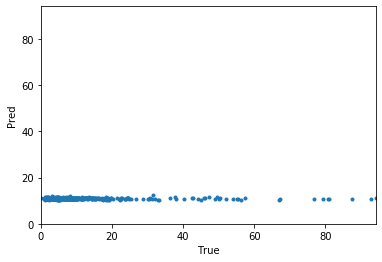

In [68]:
pred_Y = np.array(pred_Y).flatten()
plot_scatter(tmp_all[:,2], pred_Y)

Method 1: std (13.360066, 13.250528), r2 (0.157363, -1.372513)
Method 2: std (16.100431, 15.278357), r2 (0.186469, -3.988615)
Method 3: std (15.199273, 15.317250), r2 (0.215075, -3.786945)
Baseline: std (14.552871, 13.030628), r2 (0.000000, -1.766170)


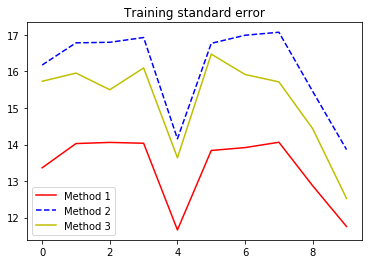

In [47]:
# Plot result
iterations = list(range(num_fold))
plt.plot(iterations, train_std[:,0], 'r-', iterations, train_std[:,1], 'b--', iterations, train_std[:,2], 'y-')
plt.legend(('Method 1', 'Method 2', 'Method 3'))
plt.title('Training standard error')

for i in range(3):
    print('Method %d: std (%f, %f), r2 (%f, %f)'%(i+1, \
        np.mean(train_std[:,i]), np.mean(test_std[:,i]), np.mean(train_r2[:,i]), np.mean(test_r2[:,i])))

print('Baseline: std (%f, %f), r2 (%f, %f)'%(np.mean(train_base), np.mean(test_base), np.mean(train_base_r2)
                                            , np.mean(test_base_r2)))

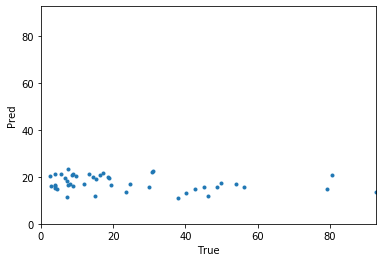

In [48]:
plot_scatter(Y_test, pred_test1)

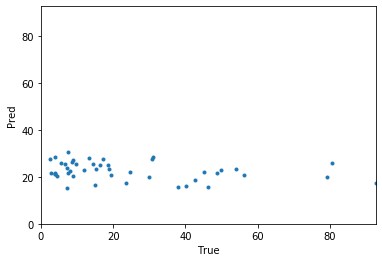

In [49]:
plot_scatter(Y_test, pred_test2)

First: 2, 0.191566
Second: 4, 0.175170


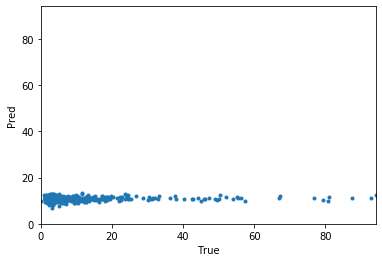

In [59]:
X, Y = preprocessing.standardize(ERSP_all, tmp_all)

# X, select_indices = preprocessing.select_correlated_ERSP(X, Y, threshold_corr=0.75)
X = X.reshape((X.shape[0],-1))

X = preprocessing.PCA_corr(X, Y)
rgr = LinearRegression()
rgr.fit(X, Y)

pred_Y = rgr.predict(X)

plot_scatter(Y, pred_Y)

In [ ]:
Y = preprocessing.make_target(SLs)
X = preprocessing.PCA_corr(ERSP_all, Y)

Y = SLs
clf = LinearRegression()
clf.fit(X, SLs)
pred_Y = clf.predict(X)

print(standard_error(pred_Y, SLs))


In [ ]:
std_list = []
r2_list = []
for remove_threshold in range(2,80,2):
    
    X_train, Y_train = preprocessing.remove_trials(ERSP_all, SLs, remove_threshold)
    
    pca = PCA(n_components=0.9)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    
    rgr = svm.SVR()
    rgr.fit(X_train, Y_train)
    pred_Y = rgr.predict(X_train)
    
    error = standard_error(Y_train, pred_Y)
    r2 = r2_score(Y_train, pred_Y)
    std_list.append(error)
    r2_list.append(r2)
    print('%d: %f, %f'%(remove_threshold, error, r2))

(array([ 3., 50., 56., 54., 38., 24., 22., 21., 16., 21., 19.,  7., 11.,
        12.,  6.,  9.,  6.,  4.,  6.,  6.,  4.,  1.,  1.,  4.,  2.,  7.,
         2.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.15234375,  1.091875  ,  2.03140625,  2.9709375 ,  3.91046875,
         4.85      ,  5.78953125,  6.7290625 ,  7.66859375,  8.608125  ,
         9.54765625, 10.4871875 , 11.42671875, 12.36625   , 13.30578125,
        14.2453125 , 15.18484375, 16.124375  , 17.06390625, 18.0034375 ,
        18.94296875, 19.8825    , 20.82203125, 21.7615625 , 22.70109375,
        23.640625  , 24.58015625, 25.5196875 , 26.45921875, 27.39875 

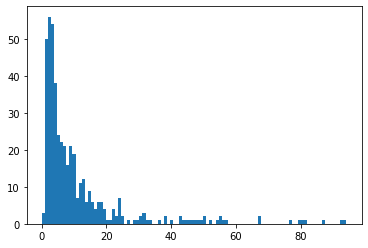

In [18]:
plt.hist(SLs, bins=100)